# House Prices: Advanced Regression Techniques
Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting
Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset.

_Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)_

## Table of Contents <a name='table'></a>
- [Load Data](#Load-Data)
- [Find 'Na' Values](#na)
  - [Explore 'Na' Values](#cleanNa)
  - [Fill 'Na' Values](#fillNa)
- [Explore Target Variable (SalePrice)](#target)
- [Explore Continuous Values](#continuous)

***

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Data <a name='Load-Data'></a>
[Table of Cotents](#table)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [265]:
X_train = train_data.copy()
X_test = test_data.copy()

In [266]:
print(X_train.shape)
print(X_test.shape)

(1460, 81)
(1459, 80)


In [267]:
def tidy(df):
    if ('Id' in df.columns):
        df.drop(columns='Id', axis=1, inplace=True)
    if ('SalePrice' in df.columns):
        y_value = df['SalePrice']
        df.drop(columns='SalePrice', axis=1, inplace=True)
        return pd.Series(y_value, name='SalePrice')
    else:
        return 

In [268]:
y_train = tidy(X_train)

In [269]:
tidy(X_test)

In [270]:
print(X_train.shape)
print(X_test.shape)

(1460, 79)
(1459, 79)


## Find and Analyse 'NA' Values <a name ='findNa'></a>
[Table of Contents](#table)

In [271]:
X_combo = pd.concat([X_train,X_test],axis=0,join='outer')
X_combo.shape

(2919, 79)

In [278]:
def find_na(df):
    na_find = df.isna().any()
    na_values = df.loc[:,na_find]
    na_col = na_values.columns.tolist()
    heatmap = sns.heatmap(X_train.isna(),cmap='binary', cbar=False, yticklabels='none')
    return heatmap

<AxesSubplot:>

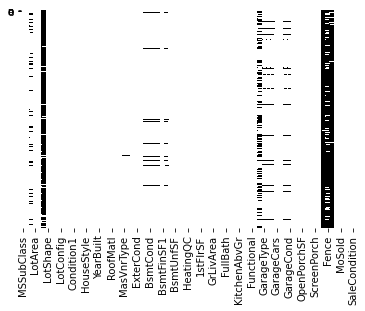

In [279]:
find_na(X_train)

<AxesSubplot:>

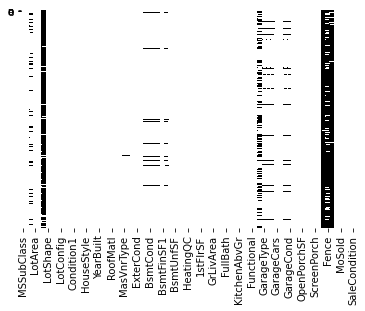

In [280]:
find_na(X_test)

In [281]:
na_sum = X_train.isna().sum().sort_values(ascending=False)
print(na_sum.loc[na_sum >= 1])
print(f'Columns with NaN values: {na_sum.loc[na_sum >= 1].count()}')

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64
Columns with NaN values: 19


### Clean 'Na' Values <a name='cleanNa'></a>
[Table of Contents](#table)

Comparing our missing values to our data dictionary many of these 'na' values are a descriptive feature of a dwelling that does not have said feature. 'PoolQC' houses without a pool don't have a 'Pool Quality' rating.

We will fill these 'na' values with 'dna' for does not apply since this is a feature in it of itself.

Column Name| 'Na' Description
-----------|---------------
MiscFeature | None
PoolQC | No Pool
Alley | No alley access
Fence | No Fence
Fireplace | No Fireplace
FireplaceQu | No Fireplace
GarageQual | No Garage
GarageYrBlt | No Garage
GarageFinish | No Garage
GarageCond | No Garage
GarageType | No Garage    
BsmtExposure | No Basement
BsmtCond | No Basement
BsmtQual | No Basement
BsmtFinType2 | No Basement
BsmtFinType1 | No Basement
MasVnrType | None
MasVnrArea | None
BsmtFullBath | None
BsmtHalfBath | None
GarageArea | No Garage

LotLotFrontage is a measurement.  We will fill this with '0'.
All other NA

In [282]:
dna = ['PoolQC','Alley','Fence','Fireplaces','FireplaceQu',\
       'GarageQual','GarageYrBlt','GarageFinish','GarageCond','GarageType',\
       'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1',\
       'MasVnrType','MasVnrArea','BsmtFullBath','BsmtHalfBath','GarageArea',\
       'MiscFeature']

In [283]:
def impute(df, features):
    dna_imputer = SimpleImputer(fill_value='dna',strategy='constant')
    imputed_out = dna_imputer.fit_transform(df[features])
    df.loc[:,features] = imputed_out
    df['LotFrontage'].fillna(value=0,inplace=True)
    print(df.isna().sum().sort_values(ascending=False))

In [284]:
impute(X_train, dna)

Electrical       1
SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
                ..
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
MSSubClass       0
Length: 79, dtype: int64


In [285]:
impute(X_test, dna)

MSZoning        4
Functional      2
Utilities       2
BsmtUnfSF       1
Exterior1st     1
               ..
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
FireplaceQu     0
MSSubClass      0
Length: 79, dtype: int64


Minimal 'Na' values after imputation.  Dropping remaining rows with 'Na' values.

In [286]:
X_test.dropna(inplace=True)
X_train.dropna(inplace=True)

In [287]:
(X_train.isna().any or X_test.isna().any) == True

False

---

## Continuous Features <a name='continuous'></a>
[Table of Contents](#table)

In [291]:
cont_values = X_train.select_dtypes(include='number').columns.tolist()

In [365]:
join_corr = X_train[cont_values].join(y_train,how='outer')
corr = join_corr.corr(method='spearman')

<AxesSubplot:>

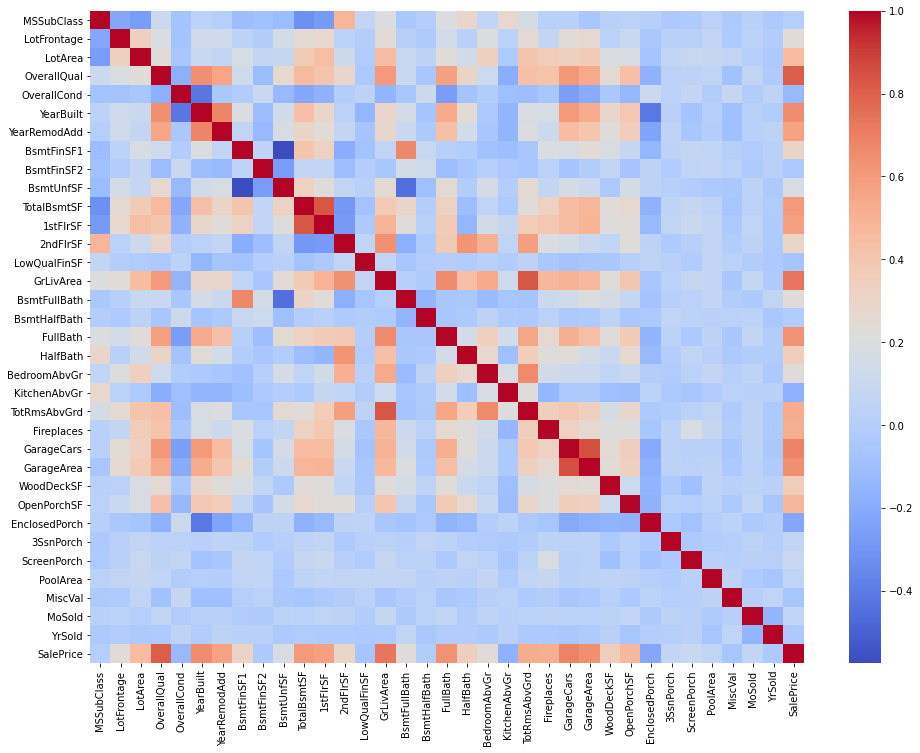

In [372]:
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm')

In [389]:
test = X_train.loc[:,cont_values].corrwith(y_train).sort_values(ascending=False)

<AxesSubplot:>

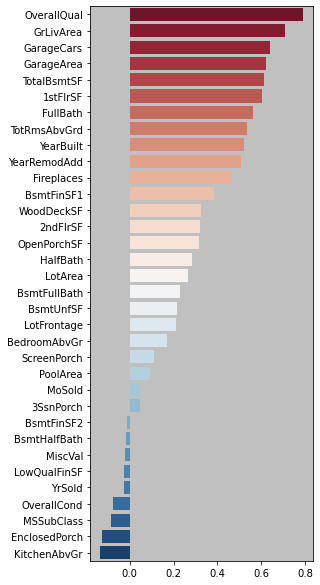

In [390]:
plt.figure(figsize=(4, len(cont_values) * .30))
plt.gca(facecolor='silver')
sns.barplot(x=test,y=test.index, orient='h', palette='RdBu')

In [65]:
na_mean =[]
na_median =[]
na_mode =[]
na_dna =[]
   

def na_sort(column, sort):
    if column not in na_col:
        return "Column doesn't contain 'Na' values."
        
    elif sort == 'mean':
        na_mean.append(column)
    elif sort == 'median':
        na_median.append(column)
    elif sort == 'mode':
        na_mode.append(column)
    elif sort == 'dna':
        na_dna.append(column)
    else:
        return 'Unkown sort value'
    
    na_col.remove(column)
    
    print(na_col)
    print(f'Remaining columns w/ "NA" values {len(na_col)}')
    
    return

In [14]:
def scribe_stats(column, df=X_train):
    if df[column].dtype == 'O':
        df[column].value_counts(normalize=True).plot(kind='bar')
        
        print(df[column].describe())
        print(f'"Na" value count: {df[column].isna().sum()}')
        print(f'"Na" % missing: {df[column].isna().sum() / len(df[column])}')

    else:
        plt.subplots(1,2, figsize=(12,4))
        
        plt.subplot(1,2,1)
        df[column].hist()
        
        plt.subplot(1,2,2)
        df[column].plot(kind='box')
        
        print(f'Median: {df[column].median()},\nMode: {df[column].mode()}, \
        \nSkew: {df[column].skew()}, \nKurtosis: {df[column].kurtosis()}, \
        \n{df[column].describe()} \n"Na" value count: {df[column].isna().sum()} ')
    return

In [15]:
na_col

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

Median: 69.0,
Mode: 0    60.0
dtype: float64,         
Skew: 2.163569142324884, 
Kurtosis: 17.452867259818404,         
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64 
"Na" value count: 259 


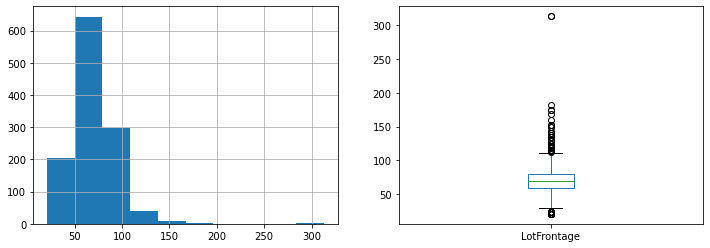

In [16]:
scribe_stats('LotFrontage')

In [17]:
na_sort('LotFrontage','mean')

['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 18


count     1452
unique       4
top       None
freq       864
Name: MasVnrType, dtype: object
"Na" value count: 8
"Na" % missing: 0.005479452054794521


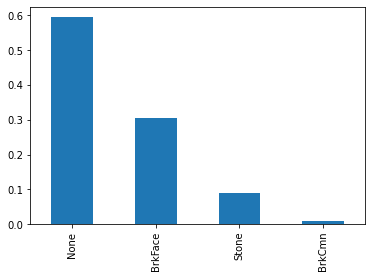

In [18]:
scribe_stats('MasVnrType')

In [19]:
na_sort('MasVnrType', 'mode')

['Alley', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 17


Median: 0.0,
Mode: 0    0.0
dtype: float64,         
Skew: 2.669084210182863, 
Kurtosis: 10.08241731736711,         
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64 
"Na" value count: 8 


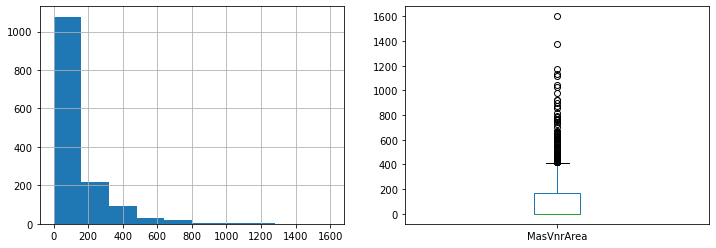

In [20]:
scribe_stats('MasVnrArea')

In [21]:
na_sort('MasVnrArea', 'mean')

['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 16


count     1423
unique       4
top         TA
freq       649
Name: BsmtQual, dtype: object
"Na" value count: 37
"Na" % missing: 0.025342465753424658


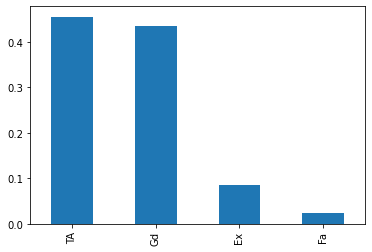

In [22]:
scribe_stats('BsmtQual')

In [23]:
na_sort('BsmtQual', 'mode')

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 15


count     1423
unique       4
top         TA
freq      1311
Name: BsmtCond, dtype: object
"Na" value count: 37
"Na" % missing: 0.025342465753424658


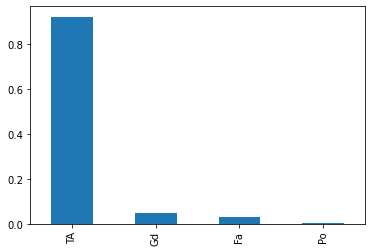

In [24]:
scribe_stats('BsmtCond')

In [25]:
na_sort('BsmtCond', 'mode')

['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 14


count     1422
unique       4
top         No
freq       953
Name: BsmtExposure, dtype: object
"Na" value count: 38
"Na" % missing: 0.026027397260273973


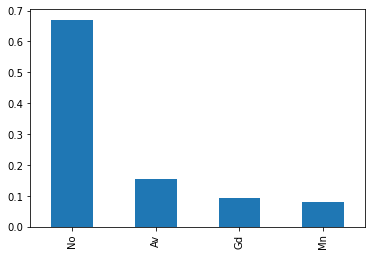

In [26]:
scribe_stats('BsmtExposure')

In [27]:
na_sort('BsmtExposure','mode')

['Alley', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 13


count     1423
unique       6
top        Unf
freq       430
Name: BsmtFinType1, dtype: object
"Na" value count: 37
"Na" % missing: 0.025342465753424658


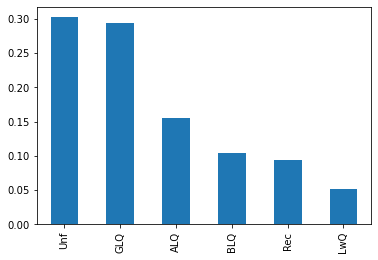

In [28]:
scribe_stats('BsmtFinType1')

In [29]:
na_sort('BsmtFinType1','mode')

['Alley', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 12


count     1422
unique       6
top        Unf
freq      1256
Name: BsmtFinType2, dtype: object
"Na" value count: 38
"Na" % missing: 0.026027397260273973


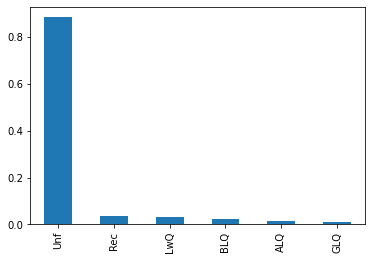

In [30]:
scribe_stats('BsmtFinType2')

In [31]:
na_sort('BsmtFinType2','mode')

['Alley', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 11


count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object
"Na" value count: 1
"Na" % missing: 0.0006849315068493151


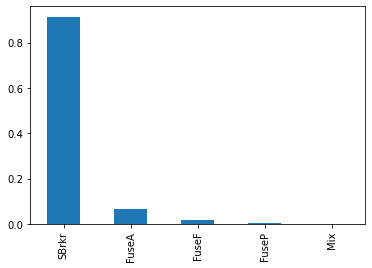

In [32]:
scribe_stats('Electrical')

In [33]:
na_sort('Electrical','mode')

['Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 10


count       1379
unique         6
top       Attchd
freq         870
Name: GarageType, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


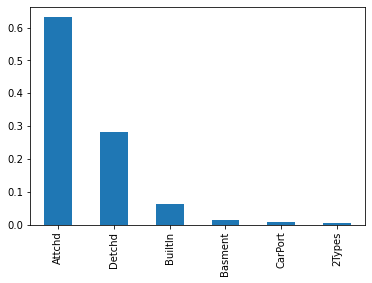

In [34]:
scribe_stats('GarageType')

In [35]:
na_sort('GarageType','mode')

['Alley', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 9


Median: 1980.0,
Mode: 0    2005.0
dtype: float64,         
Skew: -0.6494146238714679, 
Kurtosis: -0.4183409979729644,         
count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64 
"Na" value count: 81 


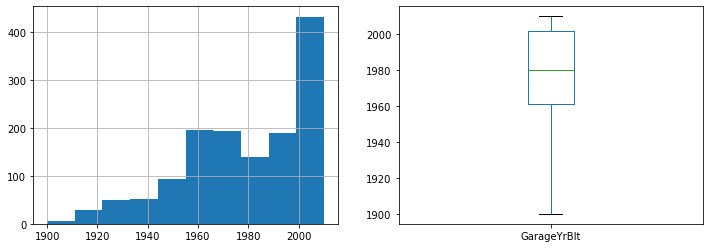

In [36]:
scribe_stats('GarageYrBlt')

In [37]:
na_sort('GarageYrBlt','mean')

['Alley', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 8


count     1379
unique       3
top        Unf
freq       605
Name: GarageFinish, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


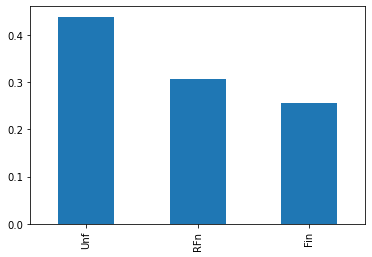

In [38]:
scribe_stats('GarageFinish')

In [39]:
na_sort('GarageFinish','mode')

['Alley', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 7


count     1379
unique       5
top         TA
freq      1311
Name: GarageQual, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


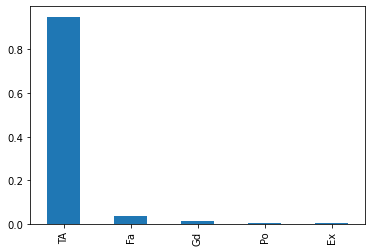

In [40]:
scribe_stats('GarageQual')

In [41]:
na_sort('GarageQual','mode')

['Alley', 'FireplaceQu', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 6


count     1379
unique       5
top         TA
freq      1326
Name: GarageCond, dtype: object
"Na" value count: 81
"Na" % missing: 0.05547945205479452


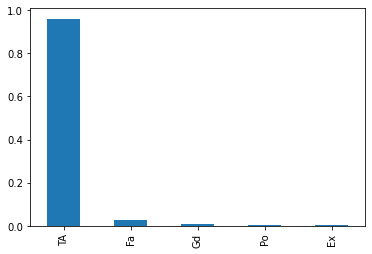

In [42]:
scribe_stats('GarageCond')

In [43]:
na_sort('GarageCond','mode')

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Remaining columns w/ "NA" values 5


---

## Target Variable (SalePrice) <a name='target'></a>
[Table of Contents](#table)

Median: 163000.0,
Mode: 0    140000
dtype: int64,         
Skew: 1.8828757597682129, 
Kurtosis: 6.536281860064529,         
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64 
"Na" value count: 0 


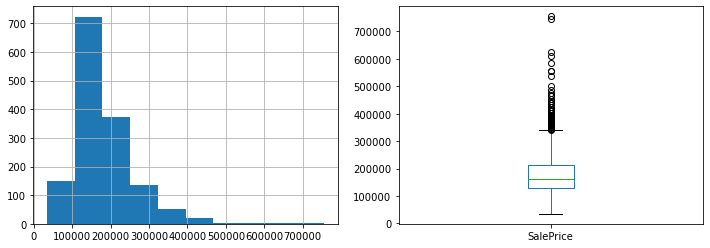

In [44]:
scribe_stats('SalePrice')

---

In [46]:
def cont_scatter(df, compare, sale_price=train_data.SalePrice):
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(1,3,1)
    plt.hist(df[compare])
    
    plt.subplot(1,3,2)
    plt.scatter(df[compare], sale_price)
    
    plt.subplot(1,3,3)
    plt.boxplot(df[compare])
    print(f'Median: {df[compare].median()},\nMode: {df[compare].mode()}, \
    \nSkew: {df[compare].skew()}, \nKurtosis: {df[compare].kurtosis()}, \n{df[compare].describe()}')
    
    return

Median: 9478.5,
Mode: 0    7200
dtype: int64,     
Skew: 12.207687851233496, 
Kurtosis: 203.24327101886033, 
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64


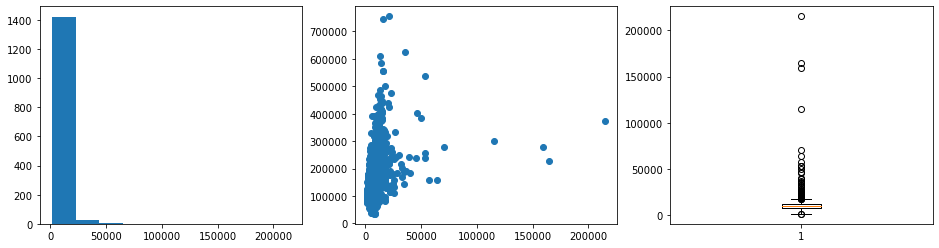

In [47]:
cont_scatter(train_data,'LotArea')

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, HuberRegressor, BayesianRidge
from sklearn.model_selection import cross_val_score

### Pipeline <a name='Pipeline'></a>
[Table of Contents](#table)

In [49]:
# X_train[na_mean] = X_train[na_mean].fillna((X_train[na_mean].mean()))
# X_train[na_mode] = X_train[na_mode].fillna(X_train[na_mode].mode().iloc[0])
# X_train.isna().sum().sort_values(ascending=False)[:14]

In [50]:
y_train = X_train.SalePrice
X_train.drop(axis=1,columns='SalePrice',inplace=True)

In [51]:
continuous_features = X_train.select_dtypes(np.number).columns.tolist()
categorical_features = X_train.select_dtypes('object').columns.tolist()

In [52]:
cont_test=  X_train.select_dtypes(np.number)
cont_test.apply(lambda x: not st.shapiro(x.fillna(0))[1] > 0.01)

Id               True
MSSubClass       True
LotFrontage      True
LotArea          True
OverallQual      True
OverallCond      True
YearBuilt        True
YearRemodAdd     True
MasVnrArea       True
BsmtFinSF1       True
BsmtFinSF2       True
BsmtUnfSF        True
TotalBsmtSF      True
1stFlrSF         True
2ndFlrSF         True
LowQualFinSF     True
GrLivArea        True
BsmtFullBath     True
BsmtHalfBath     True
FullBath         True
HalfBath         True
BedroomAbvGr     True
KitchenAbvGr     True
TotRmsAbvGrd     True
Fireplaces       True
GarageYrBlt      True
GarageCars       True
GarageArea       True
WoodDeckSF       True
OpenPorchSF      True
EnclosedPorch    True
3SsnPorch        True
ScreenPorch      True
PoolArea         True
MiscVal          True
MoSold           True
YrSold           True
dtype: bool

In [53]:
continuous_transform = Pipeline([
    ('na_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [54]:
categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='most_frequent')),
#     ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

In [55]:
preprocessor = ColumnTransformer([
    ('num', continuous_transform, continuous_features),
    ('cat', categorical_transform, categorical_features),
])

In [56]:
linear_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Linear', LinearRegression()),
])

In [57]:
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Ridge', Ridge(random_state=24)),
])

In [58]:
huber_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Huber', HuberRegressor()),
])

In [59]:
lassoCV_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', LassoCV(random_state=24, fit_intercept=True)),
])

In [60]:
bayesian_ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('BayesianRidge', BayesianRidge(n_iter=500, compute_score=True))
])

In [61]:
pipe_list = [linear_pipe, ridge_pipe, huber_pipe]
# ,lassoCV_pipe , , , bayesian_ridge_pipe

In [62]:
print('|Model|','\t','|RMSE Mean|','\t','|STD|','\t','|Scores|')
print('--' * 40)
for pipe in pipe_list:
    scores = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    scores = np.sqrt(-scores)
    print(pipe.steps[1][0],'\t',
          '{:08.6f}'.format(np.mean(scores)),'\t',
          '{:08.6f}'.format(np.std(scores)),'\t',
#          '{:08.6f}'.format(scores))
          scores)

|Model| 	 |RMSE Mean| 	 |STD| 	 |Scores|
--------------------------------------------------------------------------------
Linear 	 00000nan 	 00000nan 	 [nan nan nan nan nan]


C:\Users\Brian\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\linear_model\_base.py", line 506, in fit
    y_numeric=True, multi_output=True)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\Users\B

Ridge 	 00000nan 	 00000nan 	 [nan nan nan nan nan]
Huber 	 00000nan 	 00000nan 	 [nan nan nan nan nan]


C:\Users\Brian\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\linear_model\_huber.py", line 257, in fit
    dtype=[np.float64, np.float32])
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Brian\miniconda3\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\Users\Bri

In [63]:
predict = 

SyntaxError: invalid syntax (<ipython-input-63-5f9821895e01>, line 1)